In [115]:
import np as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.6f}".format

In [116]:
train_df = pd.read_csv(filepath_or_buffer="C:\Projects\Crosstalk\Machine_Learning\Data/2024-09-04_16-28\large_data.csv")
test_df = pd.read_csv(filepath_or_buffer="C:\Projects\Crosstalk\Machine_Learning\Data/2024-09-04_16-28/test.csv")
# validation_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/with_decay/no_j/no_j_1000.csv")

# train_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/all_expectation_values_100000.csv")
# test_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/all_expectation_values_100.csv")
# validation_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/all_expectation_values_10000.csv")
train_df.head()
print(len(train_df))

11000


In [117]:
class TrigonometricLayer(tf.keras.layers.Layer):
    def __init__(self, t, num_measurements, **kwargs):
        super(TrigonometricLayer, self).__init__(**kwargs)
        self.t = t  # Time at which measurements are taken
        self.num_measurements = num_measurements  # Number of measurement functions

    def build(self, input_shape):
        # Initialize trainable parameters

        self.trig_weights = self.add_weight(
            name='trig_weights',
            shape=(20, 8),
            initializer=tf.random_uniform_initializer(minval=0.0, maxval=1.0),
            trainable=True
        )

        super(TrigonometricLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute each measurement function based on trainable parameters
        w0, w1, j, a1, a2 = inputs[:, 0], inputs[:, 1], inputs[:, 2], inputs[:, 3], inputs[:, 4]

        x1 = tf.cos(w0 * self.t) * tf.exp(- a1 * self.t)
        x2 = tf.cos(w1 * self.t) * tf.exp(- a1 * self.t)
        x3 = tf.cos(j * self.t) * tf.exp(- a1 * self.t)
        x4 = tf.sin(w0 * self.t) * tf.exp(- a1 * self.t)
        x5 = tf.sin(w1 * self.t) * tf.exp(- a1 * self.t)
        x6 = tf.sin(j * self.t) * tf.exp(- a1 * self.t)
        x7 = tf.cos((w0 + w1) * self.t) * tf.exp(- a1 * self.t)
        x8 = tf.cos((w0 + j) * self.t) * tf.exp(- a1 * self.t)
        x9 = tf.cos((w1 + j) * self.t) * tf.exp(- a1 * self.t)
        x10 = tf.cos((w1 + j + w0) * self.t) * tf.exp(- a1 * self.t)

        x11 = tf.cos(w0 * self.t) * tf.exp(- a2 * self.t)
        x12 = tf.cos(w1 * self.t) * tf.exp(- a2 * self.t)
        x13 = tf.cos(j * self.t) * tf.exp(- a2 * self.t)
        x14 = tf.sin(w0 * self.t) * tf.exp(- a2 * self.t)
        x15 = tf.sin(w1 * self.t) * tf.exp(- a2 * self.t)
        x16 = tf.sin(j * self.t) * tf.exp(- a2 * self.t)
        x17 = tf.cos((w0 + w1) * self.t) * tf.exp(- a2 * self.t)
        x18 = tf.cos((w0 + j) * self.t) * tf.exp(- a2 * self.t)
        x19 = tf.cos((w1 + j) * self.t) * tf.exp(- a2 * self.t)
        x20 = tf.cos((w1 + j + w0) * self.t) * tf.exp(- a2 * self.t)

        trig_combinations = tf.stack([
            x1, x2, x3, x4, x5, x6, x7, x8, x9, x10,
            x11, x12, x13, x14, x15, x16, x17, x18, x19, x20
        ], axis=-1)

        outputs = tf.matmul(trig_combinations, self.trig_weights)  # Shape: (1, num_features)

        return outputs

In [118]:
import tensorflow as tf

learning_rate = 0.00005
epochs = 300
batch_size = 500

# Get all column names as a list
keys = train_df.keys().tolist()
input_keys = ['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]

output_keys = [key for key in keys if key not in input_keys]

inputs = {key: tf.keras.layers.Input(shape=(1,), name=key) for key in input_keys}
concatenated_inputs = tf.keras.layers.concatenate(list(inputs.values()))

# Prepare data for training
train_features = {key: train_df[key] for key in inputs}
train_labels = train_df[output_keys]

# Similarly prepare test and validation data
test_features = {key: test_df[key] for key in inputs}
test_labels = test_df[output_keys]


def build_model(input_layer, num_layers, nodes_per_layer=None, default_nodes=64):
    # If no list of nodes is provided, use the default number of nodes for all layers
    if nodes_per_layer is None:
        nodes_per_layer = [default_nodes] * num_layers

    # Check if nodes_per_layer has the correct number of layers
    assert len(nodes_per_layer) == num_layers, "Length of nodes_per_layer must match num_layers"

    # Build the hidden layers dynamically
    hidden_layer = input_layer
    for i in range(num_layers):
        hidden_layer = tf.keras.layers.Dense(nodes_per_layer[i], activation='relu')(hidden_layer)

    # Output layer (Assuming len(output_keys) is predefined)
    output = tf.keras.layers.Dense(len(output_keys))(hidden_layer)

    return output


nodes_per_layer = [32, 64, 64, 64, 64, 64, 64, 8]  # Optional, can be None
output = build_model(concatenated_inputs, len(nodes_per_layer), nodes_per_layer)

model = tf.keras.Model(inputs=inputs, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_absolute_error')


In [121]:

# Train the model
# history = model.fit(train_features, train_labels, validation_data=(validation_features, validation_labels), epochs=epochs, batch_size=batch_size);
history = model.fit(train_features, train_labels, validation_split=0.2, epochs=epochs, batch_size=batch_size)

# Evaluate the model
model.evaluate(test_features, test_labels)

# Extract loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0199 - val_loss: 0.0216
Epoch 2/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0200 - val_loss: 0.0217
Epoch 3/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0201 - val_loss: 0.0215
Epoch 4/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0198 - val_loss: 0.0215
Epoch 5/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0203 - val_loss: 0.0214
Epoch 6/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0198 - val_loss: 0.0214
Epoch 7/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0196 - val_loss: 0.0213
Epoch 8/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0192 - val_loss: 0.0212
Epoch 9/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194 - val_loss: 0.0211
Epoch 10/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197 - val_loss: 0.0211
Epoch 11/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0196 - val_loss: 0.0210
Epoch 12/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

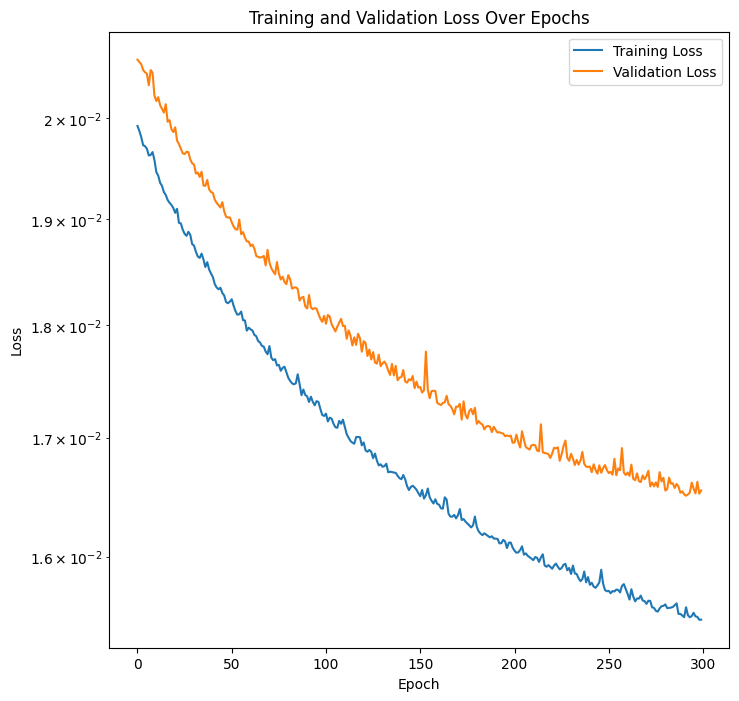

In [95]:
epochs_range = range(epochs)

# Plotting
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
#plt.xlim([1,epochs])
#plt.ylim([0,2])
plt.semilogy()
plt.show()

In [131]:
import numpy as np
import estimator

new_data = pd.read_csv("C:\Projects\Crosstalk\Machine_Learning\Data/2024-09-04_16-28/test.csv")
first_line = new_data.iloc[8]
correct_output = first_line[output_keys].array

input_data = {key: np.array([first_line[key]]) for key in inputs}
predictions = model.predict(input_data)
print("Predicted values: ", predictions[0])
print("Correct values: ", correct_output)
print("the mean squared error is: ", np.linalg.norm(predictions[0] - correct_output) ** 2)
error = estimator.percent_error(predictions[0], correct_output)
print("The percent error is: ", error * 100)

parameters = {key: first_line[key] for key in input_keys}
print(parameters)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted values:  [-0.06547321  0.56510997 -0.0729603   0.5645728  -0.67716116 -0.42320794
 -0.6808224  -0.42941982]
Correct values:  <PandasArray>
[-0.04104, 0.56048, -0.04104, 0.56048, -0.67072, -0.43712, -0.67072, -0.43712]
Length: 8, dtype: float64
the mean squared error is:  0.002050460064372477
The percent error is:  3.681715541858587
{'decay_0': 0.4355366167196668, 'decay_1': 0.5046562211072161, 'W_0': 0.8386818498585731, 'W_1': 2.041854041592219, 'J_0': -1.6803806881788437}


In [132]:
import tensorflow as tf

target_outputs = tf.constant(correct_output, dtype=tf.float32)  # Replace with your target values

# Initialize the input parameters as variables to optimize
initial_guess = {
    'decay_0': 0.5,
    'decay_1': 0.5,
    'W_0': 0,
    'W_1': 0,
    'J_0': 0
}
input_vars = {key: tf.Variable(value, dtype=tf.float32) for key, value in initial_guess.items()}


# Use the variables as inputs to the model
def model_loss(target):
    # Pass the variables through the model to get the predicted output
    model_inputs = {key: tf.expand_dims(input_vars[key], 0) for key in input_keys}
    predicted_outputs = model(model_inputs, training=False)

    # Calculate the loss between predicted and target outputs
    loss = tf.reduce_mean(tf.abs(predicted_outputs - target))
    return loss * 1000


# Set up the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Optimization loop
for step in range(300):  # Adjust the number of steps as needed
    with tf.GradientTape() as tape:
        loss = model_loss(target_outputs)
    # Compute the gradients of the loss with respect to the input variables
    grads = tape.gradient(loss, input_vars.values())
    # input_vars['J_0'].assign(-0.64)
    # Apply the gradients to the input variables
    optimizer.apply_gradients(zip(grads, input_vars.values()))

    # Print the loss and current input variables every 100 steps
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.numpy()}, Inputs: {[input_vars[key].numpy() for key in input_keys]}")

# Final optimized input parameters
optimized_inputs = {key: var.numpy() for key, var in input_vars.items()}
print("Optimized Inputs:", optimized_inputs)
print(parameters)

Step 0, Loss: 478.9243469238281, Inputs: [0.50999993, 0.50999993, 0.009999933, 0.009999934, 0.009999925]
Step 100, Loss: 188.24420166015625, Inputs: [0.4150736, 1.2955387, 0.85004985, 0.8738238, -0.23045476]
Step 200, Loss: 82.04546356201172, Inputs: [0.4566854, 1.1799601, 0.78078467, 1.8167552, -0.5949612]
Optimized Inputs: {'decay_0': 0.46180946, 'decay_1': 0.52016675, 'W_0': 0.8406878, 'W_1': 2.0144958, 'J_0': -0.71838945}
{'decay_0': 0.4355366167196668, 'decay_1': 0.5046562211072161, 'W_0': 0.8386818498585731, 'W_1': 2.041854041592219, 'J_0': -1.6803806881788437}


In [133]:


print(list(optimized_inputs.values()))
print(list(parameters.values()))

error = estimator.percent_error(np.array(list(optimized_inputs.values())), np.array(list(parameters.values())))
print(error * 100)

[0.46180946, 0.52016675, 0.8406878, 2.0144958, -0.71838945]
[0.4355366167196668, 0.5046562211072161, 0.8386818498585731, 2.041854041592219, -1.6803806881788437]
47.26177419271624


In [134]:
errors = []
for i in range(5):
    line = new_data.iloc[i]
    correct_output = line[output_keys].array
    parameters = {key: line[key] for key in input_keys}
    input_vars = {key: tf.Variable(value, dtype=tf.float32) for key, value in initial_guess.items()}
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)


    def model_loss(target):
        # Pass the variables through the model to get the predicted output
        model_inputs = {key: tf.expand_dims(input_vars[key], 0) for key in input_keys}
        predicted_outputs = model(model_inputs, training=False)

        # Calculate the loss between predicted and target outputs
        loss = tf.reduce_mean(tf.abs(predicted_outputs - target))
        return loss


    for step in range(400):  # Adjust the number of steps as needed
        with tf.GradientTape() as tape:
            loss = model_loss(correct_output)

        # Compute the gradients of the loss with respect to the input variables
        grads = tape.gradient(loss, input_vars.values())

        # Apply the gradients to the input variables
        optimizer.apply_gradients(zip(grads, input_vars.values()))

        # Print the loss and current input variables every 100 steps
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.numpy()}, Inputs: {[input_vars[key].numpy() for key in input_keys]}")
            print(np.array(list(parameters.values())))

    optimized_inputs = {key: var.numpy() for key, var in input_vars.items()}

    optimized_inputs = np.array(list(optimized_inputs.values()))
    parameters = np.array(list(parameters.values()))

    optimized_inputs = optimized_inputs[:-1]
    parameters = parameters[:-1]


    error = estimator.percent_error(optimized_inputs,parameters)
    errors.append(error)
    print("Error is: ", error * 100)
print("The mean percent error is: ", np.mean(errors) * 100)

Step 0, Loss: 0.21171358227729797, Inputs: [0.40000385, 0.40000266, -0.09999692, 0.099992916, -0.099789836]
[ 0.40452785 -0.06298816 -0.19831074  0.58587569  0.36202902]
Step 100, Loss: 0.01242877822369337, Inputs: [0.4291598, -0.07936156, -0.20011015, 0.53970003, -0.65908056]
[ 0.40452785 -0.06298816 -0.19831074  0.58587569  0.36202902]
Step 200, Loss: 0.006090142764151096, Inputs: [0.39067936, -0.084216975, -0.20674372, 0.5253976, -0.79908645]
[ 0.40452785 -0.06298816 -0.19831074  0.58587569  0.36202902]
Step 300, Loss: 0.005143921822309494, Inputs: [0.42044893, -0.067303464, -0.21855307, 0.5368339, -0.6253812]
[ 0.40452785 -0.06298816 -0.19831074  0.58587569  0.36202902]
Error is:  9.683463957946229
Step 0, Loss: 0.3371627628803253, Inputs: [0.5999964, 0.40000403, 0.09999664, -0.09999468, -0.09989882]
[ 0.59765855  0.28785614  1.35799046 -0.66207581  1.51046066]
Step 100, Loss: 0.0036354102194309235, Inputs: [0.62012124, 0.31011045, 1.3695663, -0.66393447, 0.8812371]
[ 0.59765855  0

In [28]:
import numpy as np
import estimator

new_data = pd.read_csv("C:\Projects\Crosstalk\Machine_Learning\Data/2024-08-28_14-31/test.csv")
first_line = new_data.iloc[10]
correct_output = first_line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array
#input_data = {key: [first_line[key]] for key in inputs}
input_data = {key: np.array([first_line[key]]) for key in inputs}
predictions = model.predict(input_data)
print("Predicted values: ", predictions[0][0])
print("Correct values: ", correct_output)
print("the mean squared error is: ", 0.3 * np.linalg.norm(predictions[0] - correct_output) ** 2)
error = estimator.percent_error(predictions[0], correct_output)
print("The percent error is: ", error * 100)

AttributeError: module 'sympy' has no attribute 'assumptions'

In [118]:
error = []
for i in range(len(new_data)):
    line = new_data.iloc[i]

    correct_output = line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array

    input_data = {key: np.array([line[key]]) for key in inputs}
    predictions = model.predict(input_data)
    error.append(estimator.percent_error(predictions[0], correct_output))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [119]:
print("The mean percent error is: ", np.mean(error) * 100)

The mean percent error is:  56.559793507707965


In [125]:
error_dict = {key: [] for key in ['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]}

for i in range(len(new_data)):
    line = new_data.iloc[i]

    correct_output = line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array

    input_data = {key: np.array([line[key]]) for key in inputs}
    predictions = model.predict(input_data)

    # Calculate the percent error for each output key and append it to the respective list
    for j, key in enumerate(error_dict.keys()):
        error_dict[key].append(estimator.percent_error(predictions[0][0][j], correct_output[j]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [126]:
import pandas as pd

# Convert the error dictionary to a DataFrame
error_df = pd.DataFrame(error_dict)

# Calculate the mean of each error
mean_errors = error_df.mean()

# Display the results
for key, value in mean_errors.items():
    print(f"The mean error for {key} is: {value * 100} precent")

print("total error is: ", mean_errors.mean() * 100)

The mean error for decay_0 is: 21.14048892259431 precent
The mean error for decay_1 is: 29.513848007879584 precent
The mean error for W_0 is: 408.22536167818157 precent
The mean error for W_1 is: 32.036623575115335 precent
The mean error for J_0 is: 8072.218115692011 precent
total error is:  1712.6268875751566


In [13]:

print(custom_loss(predictions[0], correct_output))
a = custom_loss(predictions[0], correct_output)

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Mul] name: 